In [1]:
import itertools
from itertools import count
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import collections
from random import randint
from matplotlib import style

from google.colab import drive
drive.mount('/content/drive')

file_path = "/content/drive/My Drive/Colab Notebooks/IPRAD/scenario_train.csv"
df = pd.read_csv(file_path)


Mounted at /content/drive


In [2]:
#read data into ndarray

data = np.loadtxt(file_path, delimiter= ",", skiprows=1)

In [3]:
#load ndarray into dataframe
df_LU3 = pd.DataFrame(data, columns=['index', 'floor_size', 'households', 'median_income', 'median_house_value' ])

In [4]:
#display the top 5 rows
df.head()

,Unnamed: 0,floor_size,households,median_income,median_house_value
0,15342,2204.0,462.0,3.68,125600.0
1,13659,1658.0,304.0,5.14,136700.0
2,7151,2006.0,463.0,1.80,158800.0
3,4410,2050.0,418.0,3.56,210000.0
4,14925,2346.0,382.0,5.52,156300.0


In [5]:
df_LU3.head()

,index,floor_size,households,median_income,median_house_value
0,15342.0,2204.0,462.0,3.68,125600.0
1,13659.0,1658.0,304.0,5.14,136700.0
2,7151.0,2006.0,463.0,1.80,158800.0
3,4410.0,2050.0,418.0,3.56,210000.0
4,14925.0,2346.0,382.0,5.52,156300.0


In [6]:
#sort dataframe by index
df_LU3= df_LU3.sort_values(by='index')

In [7]:
df_LU3.head()

,index,floor_size,households,median_income,median_house_value
12562,1.0,7099.0,1138.0,8.30,358500.0
3809,6.0,2535.0,514.0,3.66,299200.0
12144,7.0,3104.0,647.0,3.12,241400.0
8856,8.0,2555.0,595.0,2.08,226700.0
3332,9.0,3549.0,714.0,3.69,261100.0


In [8]:
def moving_average(data, window_size):
    """ Computes moving average using discrete linear convolution of two one dimensional sequences.
    Args:
    -----
            data (pandas.Series): independent variable
            window_size (int): rolling window size

    Returns:
    --------
            ndarray of linear convolution

    References:
    ------------
    [1] Wikipedia, "Convolution", http://en.wikipedia.org/wiki/Convolution.
    [2] API Reference: https://docs.scipy.org/doc/numpy/reference/generated/numpy.convolve.html

    """
    window = np.ones(int(window_size))/float(window_size)
    return np.convolve(data, window, 'same')

In [9]:
def explain_anomalies(y, window_size, sigma=1.0):
    """ Helps in exploring the anamolies using stationary standard deviation
    Args:
    -----
        y (pandas.Series): independent variable
        window_size (int): rolling window size
        sigma (int): value for standard deviation

    Returns:
    --------
        a dict (dict of 'standard_deviation': int, 'anomalies_dict': (index: value))
        containing information about the points indentified as anomalies

    """
    avg = moving_average(y, window_size).tolist()
    
    residual = y - avg
    # Calculate the variation in the distribution of the residual
    std = np.std(residual)

    return {'standard_deviation': round(std, 3),
            'anomalies_dict': collections.OrderedDict([(index, y_i) for
                                                       index, y_i, avg_i in zip(count(), y, avg)
              if (y_i > avg_i + (sigma*std)) | (y_i < avg_i - (sigma*std))])}

In [16]:
def explain_anomalies_rolling_std(y, window_size, sigma=1.0):
    """ Helps in exploring the anamolies using rolling standard deviation
    Args:
    -----
        y (pandas.Series): independent variable
        window_size (int): rolling window size
        sigma (int): value for standard deviation

    Returns:
    --------
        a dict (dict of 'standard_deviation': int, 'anomalies_dict': (index: value))
        containing information about the points indentified as anomalies
    """
    avg = moving_average(y, window_size)
    avg_list = avg.tolist()
    residual = y - avg
    # Calculate the variation in the distribution of the residual
    
    # to check this line
    # testing_std = pd.rolling_std(residual, window_size)
    testing_std = residual.rolling(window=window_size).std()

    testing_std_as_df = pd.DataFrame(testing_std)

    # to check this line
    # rolling_std = testing_std_as_df.replace(np.nan,testing_std_as_df.ix[window_size - 1]).round(3).iloc[:,0].tolist()
    rolling_std = testing_std_as_df.replace(np.nan,testing_std_as_df.iloc[window_size - 1]).round(3).iloc[:,0].tolist()

    std = np.std(residual)
    return {'stationary standard_deviation': round(std, 3),
            'anomalies_dict': collections.OrderedDict([(index, y_i)
                                                       for index, y_i, avg_i, rs_i in zip(count(),
                                                                                          y, avg_list, rolling_std)

                                                       if (y_i > avg_i + (sigma * rs_i)) | (y_i < avg_i - (sigma * rs_i))])}


In [11]:
# This function is repsonsible for displaying how the function performs on the given dataset.
def plot_results(x, y, window_size, sigma_value=1,
                 text_xlabel="X Axis", text_ylabel="Y Axis", applying_rolling_std=False):
    """ Helps in generating the plot and flagging the anamolies.
        Supports both moving and stationary standard deviation. Use the 'applying_rolling_std' to switch
        between the two.
    Args:
    -----
        x (pandas.Series): dependent variable
        y (pandas.Series): independent variable
        window_size (int): rolling window size
        sigma_value (int): value for standard deviation
        text_xlabel (str): label for annotating the X Axis
        text_ylabel (str): label for annotatin the Y Axis
        applying_rolling_std (boolean): True/False for using rolling vs stationary standard deviation
    """
    plt.figure(figsize=(15, 8))
    plt.plot(x, y, "k.")
    y_av = moving_average(y, window_size)
    plt.plot(x, y_av, color='green')
    plt.xlim(0, 1000)
    plt.xlabel(text_xlabel)
    plt.ylabel(text_ylabel)

    # Query for the anomalies and plot the same
    events = {}
    if applying_rolling_std:
        events = explain_anomalies_rolling_std(y, window_size=window_size, sigma=sigma_value)
    else:
        events = explain_anomalies(y, window_size=window_size, sigma=sigma_value)
        

    x_anomaly = np.fromiter(events['anomalies_dict'].keys(), dtype=int, count=len(events['anomalies_dict']))
    y_anomaly = np.fromiter(events['anomalies_dict'].values(), dtype=float,
                                        count=len(events['anomalies_dict']))
    plt.plot(x_anomaly, y_anomaly, "r*", markersize=12)

    # add grid and lines and enable the plot
    plt.grid(True)
    plt.show()

In [12]:
x = df_LU3 ['index']
Y = df_LU3 ['median_house_value']

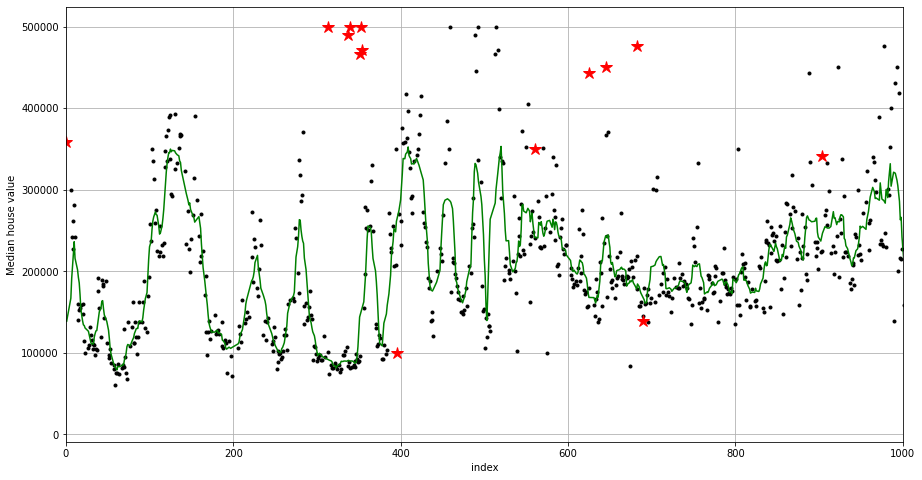

In [18]:
#Uncomment this line to liks the 
# plot the results
plot_results(x, y=Y, window_size=10, text_xlabel="index", sigma_value=3, text_ylabel="Median house value")
events = explain_anomalies(Y, window_size=5, sigma=3)


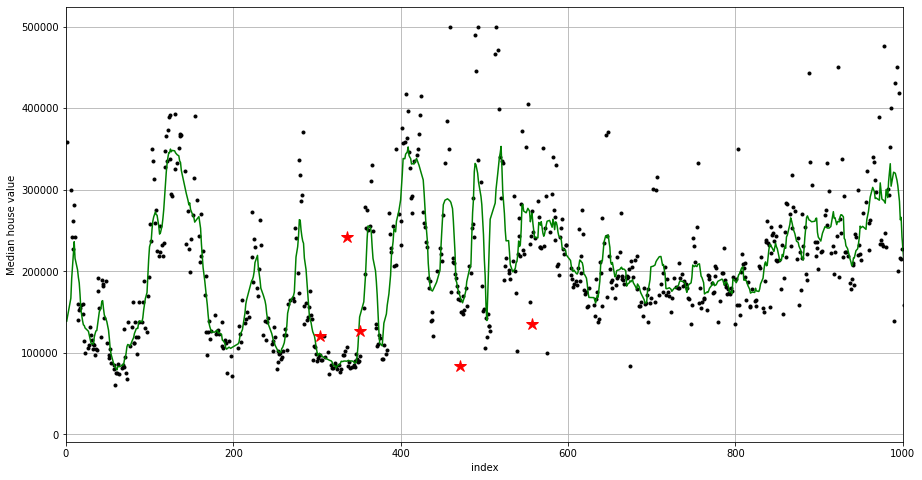

In [19]:
#Uncomment this line to liks the 
# plot the results
plot_results(x, y=Y, window_size=10, text_xlabel="index", sigma_value=3, text_ylabel="Median house value", applying_rolling_std=True)
events = explain_anomalies(Y, window_size=5, sigma=3)


In [14]:
# Display the anomaly dict
print("Information about the anomalies model:{}".format(events))

Information about the anomalies model:{'standard_deviation': 43008.006, 'anomalies_dict': OrderedDict([(0, 358500.0), (313, 500001.0), (340, 500001.0), (351, 126900.0), (380, 405400.0), (396, 100000.0), (449, 371200.0), (560, 350000.0), (625, 442900.0), (645, 451100.0), (683, 475800.0), (690, 139300.0), (693, 200200.0), (904, 340900.0), (1104, 200000.0), (1105, 500001.0), (1107, 188500.0), (1121, 294400.0), (1129, 426100.0), (1157, 162500.0), (1161, 210100.0), (1162, 181200.0), (1292, 22500.0), (1359, 500001.0), (1575, 345900.0), (2211, 275000.0), (2293, 225000.0), (2447, 431800.0), (2455, 450700.0), (2456, 152100.0), (2457, 160200.0), (2459, 500001.0), (2495, 500001.0), (2505, 500001.0), (2506, 193300.0), (2522, 454400.0), (2627, 465800.0), (2662, 500001.0), (2663, 140500.0), (2704, 500001.0), (2772, 500001.0), (2818, 483100.0), (2824, 189300.0), (2828, 259600.0), (2976, 283300.0), (3196, 500001.0), (3209, 400000.0), (3245, 166700.0), (3248, 500001.0), (3249, 75000.0), (3269, 417600.0

In [15]:
pd.__version__

'1.1.5'